In [1]:
%env JAX_PLATFORMS=cpu
%load_ext autoreload
%autoreload 2
import jax
import jax.numpy as jnp

env: JAX_PLATFORMS=cpu


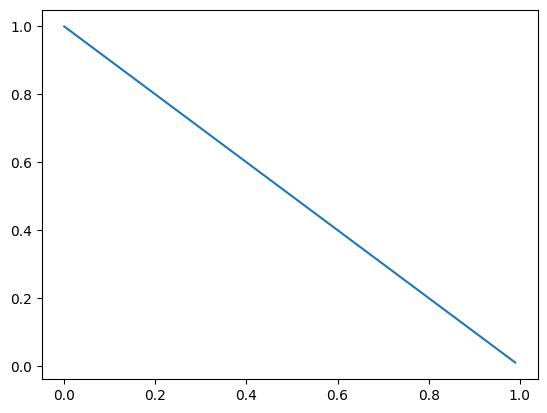

In [3]:
from src.jif.diffusion import MDLMDiffusion
n_classes = 8
seq_len = 4
batch = 6
diffusion = MDLMDiffusion(n_classes, 1e-7)
data = jax.random.randint(jax.random.PRNGKey(0), (batch, seq_len), 0, n_classes)


from matplotlib import pyplot as plt
t = jnp.arange(0, 1, 0.01)
plt.plot(t, diffusion.alpha(t))
plt.show()

In [4]:
import math


# https://github.com/neverix/Score-Entropy-Discrete-Diffusion/blob/f7221e3b835045f75444c7429955aa420111cc7d/model/transformer.py#L80
def timestep_embedding(t, dim, max_period=10000):
    # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
    half = dim // 2
    freqs = jnp.exp(
        -math.log(max_period) * jnp.arange(0, half, dtype=jnp.float32) / half
    )
    args = t[..., None].astype(jnp.float32) * freqs[None]
    embedding = jnp.concatenate([jnp.cos(args), jnp.sin(args)], axis=-1)
    if dim % 2:
        embedding = jnp.cat([embedding, jnp.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


In [7]:
from functools import partial
import optax
from tqdm import trange
key_params = jax.random.key(3)
key_w1, key_w2, key_w3, key_b1, key_b2, key_b3 = jax.random.split(key_params, 6)
n_time = 128
in_dim = (n_classes + 1) * seq_len + n_time
d = 1024
out_dim = (n_classes + 1) * seq_len
scale_in = math.sqrt(in_dim)
scale_out = math.sqrt(out_dim)
w1, w2, w3 = jax.random.normal(key_w1, (in_dim, d)) / scale_in, jax.random.normal(key_w2, (in_dim, d)) / scale_in, jax.random.normal(key_w3, (d, out_dim)) / scale_out
b1, b2, b3 = jax.random.normal(key_b1, (d,)) * 0.1, jax.random.normal(key_b2, (d,)) * 0.1, jax.random.normal(key_b3, (out_dim,)) * 0.1
params = w1, w2, w3, b1, b2, b3

def run_net(params, data_perturbed, total_noise):
    x = jnp.concatenate([jax.nn.one_hot(data_perturbed, n_classes + 1).reshape(*data_perturbed.shape[:-1], -1) * 2 - 1, timestep_embedding(total_noise[..., 0], n_time).reshape(*data_perturbed.shape[:-1], -1)], -1)
    w1, w2, w3, b1, b2, b3 = params
    # h = (x @ w1 + b1) * (x @ w2 + b2)
    # h = jax.nn.relu(x @ w1 + b1)
    h = jax.nn.relu(x @ w1 + b1) * (x @ w2 + b2)
    logits = (h @ w3 + b3).reshape(*data_perturbed.shape, n_classes + 1)
    return logits

def get_loss(params, data, key):
    loss = diffusion.get_loss(key, partial(run_net, params), data)
    return loss.mean()

@partial(jax.jit, donate_argnums=(0, 3))
def update_step(params, data, key, opt_state):
    loss, grad = jax.value_and_grad(get_loss)(params, data, key)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

loss_and_grad = jax.value_and_grad(get_loss)
optimizer = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(4e-4))
ema_params = jax.tree.map(jnp.copy, params)
opt_state = optimizer.init(params)
losses = []
train_chunk = 128
for i in (bar := trange(8192)):
    key = jax.random.PRNGKey(i)
    # loss, grad = loss_and_grad(params, data.repeat(16, 0), key)
    # updates, opt_state = optimizer.update(grad, opt_state, params)
    # params = optax.apply_updates(params, updates)
    params, opt_state, loss = update_step(params, data.repeat(128, 0), key, opt_state)
    ema_params = jax.tree.map(lambda x, y: x * 0.99 + y * 0.01, ema_params, params)
    bar.set_postfix(loss=loss)
    losses.append(loss)

  0%|          | 0/8192 [00:00<?, ?it/s]

100%|██████████| 8192/8192 [02:07<00:00, 64.09it/s, loss=0.009358923] 


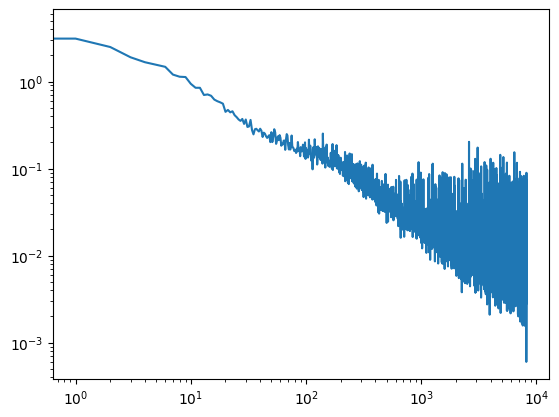

In [8]:
from matplotlib import pyplot as plt
plt.plot(losses)
plt.yscale("log")
plt.xscale("log")

In [20]:
import random
import jax
closenesses = jax.vmap(lambda key: (diffusion.sample(lambda x, t: run_net(ema_params, x, t), key, 256, (seq_len,)) == data))(jax.random.split(jax.random.key(0), 32))
# p = closenesses.mean(2)
# p = p / p.sum(-1, keepdims=True)
# closenesses.min(2).max(1).mean(), p.mean(0)
eq = 0
corr = 0
for sample in closenesses:
    correct = sample.all(-1)
    corr = corr + correct.any()
    if correct.any():
        eq = eq + correct
corr / len(closenesses), eq / corr

[0.00390625 0.00390625 0.00390625 0.00390625]
[0.00390625 0.00390625 0.00390625 0.00390625]
[0.00390625 0.00390625 0.00390625 0.00390625]
[0.00390625 0.00390625 0.00390625 0.00390625]
[0.00390625 0.00390625 0.00390625 0.00390625]
[0.00390625 0.00390625 0.00390625 0.00390625]
[0.00390625 0.00390625 0.00390625 0.00390625]
[0.00390625 0.00390625 0.00390625 0.00390625]
[0.00390625 0.00390625 0.00390625 0.00390625]
[0.00390625 0.00390625 0.00390625 0.00390625]
[0.00390625 0.00390625 0.00390625 0.00390625]
[0.00390625 0.00390625 0.00390625 0.00390625]
[0.00390625 0.00390625 0.00390625 0.00390625]
[0.00390625 0.00390625 0.00390625 0.00390625]
[0.00390625 0.00390625 0.00390625 0.00390625]
[0.00390625 0.00390625 0.00390625 0.00390625]
[0.00390625 0.00390625 0.00390625 0.00390625]
[0.00390625 0.00390625 0.00390625 0.00390625]
[0.00390625 0.00390625 0.00390625 0.00390625]
[0.00390625 0.00390625 0.00390625 0.00390625]
[0.00390625 0.00390625 0.00390625 0.00390625]
[0.00390625 0.00390625 0.00390625 

(Array(0.84375, dtype=float32, weak_type=True),
 Array([0.        , 0.        , 0.        , 0.        , 0.07407407,
        0.9259259 ], dtype=float32, weak_type=True))

In [ ]:
import numpy as np
key = jax.random.key(0)
score_fn = partial(run_net, ema_params)
noise_key, transition_key = jax.random.split(key, 2)
x = data.repeat(128, 0)
t = jax.random.uniform(noise_key, x.shape[:-1] + (1,))
total_noise, rate_noise = diffusion.noise_schedule(t)
data_perturbed = diffusion.sample_transition(transition_key, x, total_noise)
logits = score_fn(data_perturbed, total_noise)
# logits[..., -1]
xs = []
for i in range(len(t)):
    for j, (l, u) in enumerate(zip(logits[i], data_perturbed[i] == n_classes)):
        # if not u:
            # continue
        probs = diffusion.staggered_score(jnp.exp(l), rate_noise[i, 0]) * diffusion.transp_transition(x[i], rate_noise[i])[j]
        l_last = (probs / (1e-10 + probs.sum()))[..., -1]
        xs.append((float(t[i, 0]), float(l_last)))
plt.scatter(*np.array(xs).T)
plt.ylim(-200, 10)